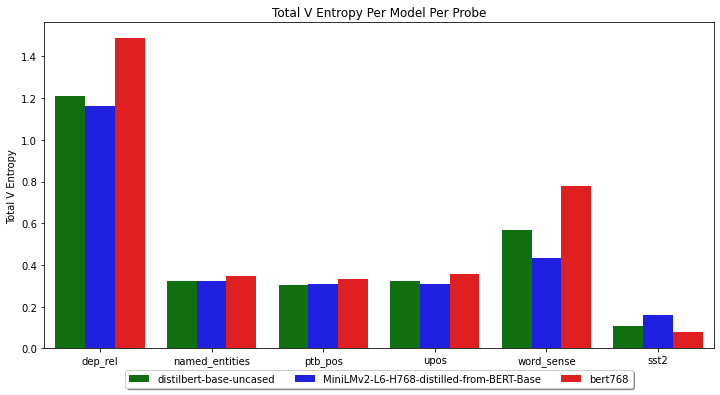

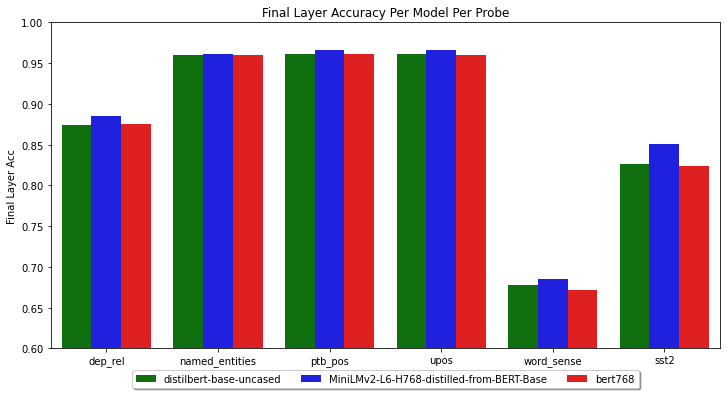

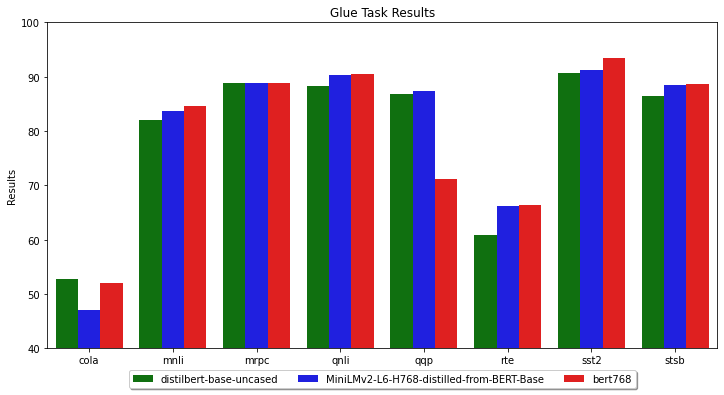

In [99]:
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import pandas as pd

# bar ands lines are models
# y axis = infomration gain
# x axis = bar chart probes
# scatter = performance of glue task (y = axis glue acc, x axis = glue tasks)
#distilbert-base-uncased","MiniLMv2-L6-H768-distilled-from-BERT-Base and bert768

glue_tasks = ["qnli","mrpc","rte","cola","mnli","qqp","stsb","sst2"]
probe_tasks=["dep_rel","named_entities","ptb_pos","upos","word_sense","sst2"]
models = ["distilbert-base-uncased","MiniLMv2-L6-H768-distilled-from-BERT-Base","bert768"]
layer_numbers=[6,6,12]


# def get_total_probe_v_entropy(task,model_name,layer_number):
#     file_paths = ['reports/{}-{}-layer{}-{}.yaml.results/dev.v_entropy'.format(task,model_name,i,i+1) for i in range(0,layer_number)] 
#     total_acc = []
#     for file_path in file_paths: 
#         if os.path.isfile(file_path):
#             with open(file_path, "r") as f:
#                 total_acc.append(float(f.read().strip()))
#         else:
#             print("Path Invalid" + file_path)
#     return sum(total_acc)

def final_acc(task,model_name,layer_number):
    file_path = 'reports/{}-{}-layer{}.yaml.results/dev.label_acc'.format(task,model_name,layer_number) 
    if os.path.isfile(file_path):
        with open(file_path, "r") as f:
            return float(f.read().strip())
    else:
        print("Path Invalid" + file_path)



def get_total_probe_v_entropy(task,model_name,layer_number):
    single_layers = ['reports/{}-{}-layer{}.yaml.results/dev.v_entropy'.format(task,model_name,i) for i in range(0,layer_number)] #(0-5)
    two_layers = ['reports/{}-{}-layer{}-{}.yaml.results/dev.v_entropy'.format(task,model_name,i,i+1) for i in range(0,layer_number)] #(0-1),(1,2)
    base = []
    cond = []
    for file_path in single_layers:
        if os.path.isfile(file_path):
            with open(file_path, "r") as f:
                base.append(float(f.read().strip()))
        else:
            print("Path Invalid")

    for two_layer_file_path in two_layers:
        if os.path.isfile(two_layer_file_path):
            with open(two_layer_file_path, "r") as f:
                cond.append(float(f.read().strip()))
        else:
            print("Path Invalid")
    r = [(b-c) for b, c in zip(base, cond)]
    return sum(r)

def get_glue_acc(glue_task,model_name,glue_data):
    model_condtion = glue_data["Model"] == model_name
    task_condtion = glue_data["Task"] == glue_task
    return glue_data.loc[(model_condtion & task_condtion)]["Training Results"].iat[0]

df = pd.DataFrame(columns = ['Probe Task','Models','Total V Entropy'])
for count, model in enumerate(models):
    for probe_task in probe_tasks:
        total_v_entropy = get_total_probe_v_entropy(probe_task, model,layer_numbers[count])
        df.loc[len(df)] = [probe_task, model, total_v_entropy]

plt.figure(figsize=(12,6))
plt.title("Total V Entropy Per Model Per Probe")
sns.barplot(data=df, x='Probe Task', y='Total V Entropy', hue='Models',palette=["green","blue","red"])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3)
plt.show()

df_acc = pd.DataFrame(columns = ['Probe Task','Models','Final Layer Acc'])
for count, model in enumerate(models):
    for probe_task in probe_tasks:
        acc = final_acc(probe_task, model,layer_numbers[count])
        df_acc.loc[len(df_acc)] = [probe_task, model, acc]

plt.figure(figsize=(12,6))
plt.title("Final Layer Accuracy Per Model Per Probe")
plt.ylim(0.6, 1)
sns.barplot(data=df_acc, x='Probe Task', y='Final Layer Acc', hue='Models',palette=["green","blue","red"])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3)
plt.show()

glue_data = pd.read_excel("grouped_data.xlsx")
glue_data_trimmed = glue_data.loc[glue_data['Model'].isin(models)]

plt.figure(figsize=(12,6))
plt.title("Glue Task Results")
plt.ylim(40, 100)
sns.barplot(data=glue_data_trimmed, x="Glue Task", y="Results", hue="Model", palette=["green","blue","red"])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=3)
plt.show()